# GHZ state in Rydberg atoms (CUDA)

In [1]:
using Sisyphus
using QuantumOptics
using LinearAlgebra
using Flux, DiffEqFlux
using Plots
using ProgressMeter
using Random
ProgressMeter.ijulia_behavior(:clear)

false

In [2]:
bs = SpinBasis(1//2)
sx = sigmax(bs)
ni = 0.5*(identityoperator(bs) + sigmaz(bs));

In [3]:
V = 2π*24.0
δe = -2π*4.5

-28.274333882308138

In [4]:
n_atoms = 12
bsys = tensor([bs for i in 1:n_atoms]...)

H0 = V*sum([embed(bsys, [i, j], [ni, ni])/abs(i-j)^6  for i in 1:n_atoms for j in i+1:n_atoms])
H0 -= δe*sum([embed(bsys, [i], [ni]) for i in [1, n_atoms]])
if n_atoms>8
    H0 -= -2π*1.5*sum([embed(bsys, [i], [ni]) for i in [1, n_atoms]])
    H0 -= -2π*1.5*sum([embed(bsys, [i], [ni]) for i in [4, n_atoms-3]])
end;

H1 = 0.5*sum([embed(bsys, [i], [sx]) for i in 1:n_atoms])
H2 = -sum([embed(bsys, [i], [ni]) for i in 1:n_atoms]);

In [5]:
function GHZ_state(n_atoms)
    state = tensor([spindown(bs)⊗spinup(bs) for i in 1:Int(n_atoms/2)]...) +
            tensor([spinup(bs)⊗spindown(bs) for i in 1:Int(n_atoms/2)]...)
    state/sqrt(2.0)
end 

ground_state(n_atoms) = tensor([spindown(bs) for i in 1:n_atoms]...)
trans = StateTransform(ground_state(n_atoms)=>GHZ_state(n_atoms));

In [6]:
n_neurons = 8
sigmoid(x)= @. 2π*7 / (1 + exp(-x))
Random.seed!(10)
ann = FastChain(FastDense(1, n_neurons, tanh), 
                FastDense(n_neurons, n_neurons, tanh), 
                FastDense(n_neurons, 2))
θ = initial_params(ann)  
n_params = length(θ)

106

In [7]:
t0, t1 = 0.0, 0.5

tsf32 = Float32(t0):Float32(t1/49):Float32(t1)
Ωs = Vector{Float32}(2π*vcat(0:0.5:4, 5*ones(32), 4:-0.5:0))
Δs = Vector{Float32}(2π*(-5:10/49:5))
ts = Vector{Float64}(tsf32)

function loss(p)
    c = 0.0f0
    for (i,t) in enumerate(tsf32)
        x = ann([t], p)
        c += (abs(x[1]) - Ωs[i])^2
        c += (x[2] - Δs[i])^2
    end
    #println(c)
    c
end

res = DiffEqFlux.sciml_train(loss, initial_params(ann), ADAM(0.1f0), maxiters = 5000)
θ = Vector{Float64}(res.u);

In [8]:
coeffs(params, t) = let vals = ann([t], params)
                        [abs(vals[1]), vals[2]]
                    end    

cost = CostFunction((x, y) -> 1.0 - abs(sum(conj(x).*y)),
                     p->2e-3*(abs(ann([t0], p)[1])+ 5.0*abs(ann([t1], p)[1])))

CostFunction(var"#23#25"(), var"#24#26"())

In [9]:
H = Hamiltonian(H0, [H1, H2], coeffs);

In [10]:
prob = cu(convert(Float32, QOCProblem(H, trans, (t0, t1), cost)));

In [11]:
@time sol = solve(prob, res.u, ADAM(0.1f0); maxiter=200, abstol=1e-5, reltol=1e-5)

Progress: 100%|█████████████████████████████████████████| Time: 0:24:04
  distance:     0.015626370906829834
  constraints:  0.00787696664318554


1477.884612 seconds (5.61 G allocations: 139.938 GiB, 9.92% gc time, 4.95% compilation time)


Solution{Float32}(Float32[-4.9095097, -3.258889, 3.6414409, -4.336866, -9.806632, -8.169109, 8.890097, -3.5882354, 0.9342948, 1.4838762  …  3.554006, -6.394788, 7.13117, -7.1935782, 1.7162676, 17.924551, 19.362608, 3.5637567, 1.9719929, 6.20059], Float32[0.89177257, 0.81607366, 0.8562323, 0.7666775, 0.8015005, 0.81758726, 0.7245367, 0.69440055, 0.69403017, 0.64353585  …  0.017134845, 0.019722283, 0.019384205, 0.017207801, 0.015501082, 0.017275393, 0.018748641, 0.0206362, 0.016470194, 0.01562637], Float32[0.010842906, 0.04914394, 0.05029069, 0.039492287, 0.018102482, 0.026509503, 0.016885282, 0.032451477, 0.035936307, 0.028652746  …  0.0072718617, 0.0016285173, 0.00038689838, 0.008437778, 0.011504921, 0.0068363417, 0.0026388576, 0.0023839504, 0.0051434184, 0.007876967], Vector{Float32}[])

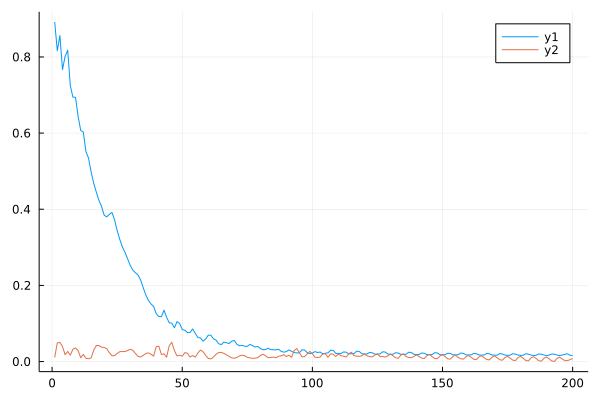

In [12]:
plot(sol.distance_trace)
plot!(sol.constraints_trace)

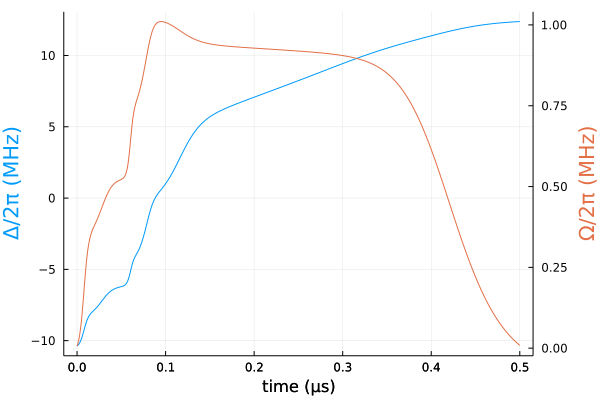

In [16]:
Ω(t) = abs(ann([t], sol.params)[1])/2π
Δ(t) = ann([t], sol.params)[2]/2π
ts = Vector{Float32}(collect(t0:0.001:t1))

blue = theme_palette(:auto).colors.colors[1]
red = theme_palette(:auto).colors.colors[2]
plot(ts, Δ.(ts), ylabel="Δ/2π (MHz)",
     color=blue, yguidefont = font(blue), legend=false)
plot!(Plots.twinx(), ts, Ω.(ts)/2π,
     ylabel="Ω/2π (MHz)", color=red, yguidefont = font(red), legend=false)
plot!(xlabel="time (μs)", right_margin = 15Plots.mm)

In [14]:
tout, psit = schroedinger_dynamic(ts, ground_state(n_atoms), H, Vector{Float64}(sol.params));

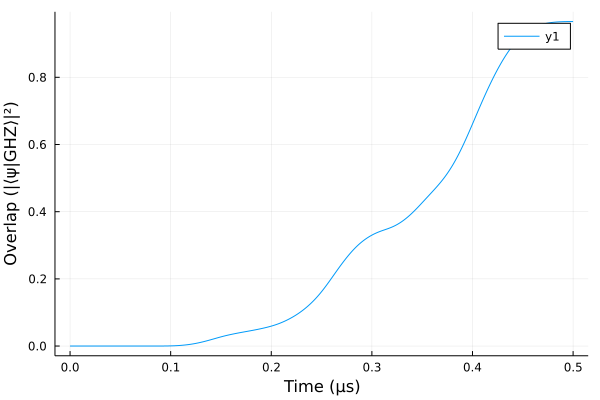

In [15]:
plot(ts, real(expect(dm(GHZ_state(n_atoms)), psit)))
xlabel!("Time (µs)")
ylabel!("Overlap (|⟨ψ|GHZ⟩|²)")